In [1]:
import cv2
import numpy as np

In [2]:
import torch
from torchvision import transforms
from torchvision.transforms import *

def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    w, h = 302, 464
    y[0] = (w * (x[0] - x[2] / 2))
    y[1] = (h * (x[1] - x[3] / 2))
    y[2] = (w * (x[0] + x[2] / 2))
    y[3] = (h * (x[1] + x[3] / 2))
    return y.round(4)

def transform(im):
    transform = transforms.Compose([
            ToTensor(),
            Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)),
        ])
    return transform(im)

In [3]:
img_infos = []
with open('test.txt','r',encoding='UTF-8') as f:
    lines = f.readlines()
for line in lines:
    img_infos.append(list(map(float, line.strip().split())))

x = img_infos[0][1:]
y = xywh2xyxy(x)
for img_info in img_infos:
    x = img_info[1:]
    img_info[1:] = xywh2xyxy(x)


In [4]:
from model import ClsModel
from collections import defaultdict
import os
import torch

import numpy as np
import matplotlib.pyplot as plt
import cv2

import pandas as pd

datasheet = pd.read_csv('datasheet.csv')
datasheet.drop(['Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', ], axis=1, inplace=True)
print(datasheet.head())

model_root = '/opt/ml/data/final-project-level3-cv-17/classification/model/'
model_info = defaultdict(dict)
for i in range(14):
    if i==2 or i==12:
        continue
    model_info['path'][i+1] = model_root + f'data_{i+1}/best.pth'
model_info['cls'][5]=sorted(os.listdir('/opt/ml/data/final-project-level3-cv-17/classification/train_05/resize224'))
model_info['cls'][11] = sorted(os.listdir('/opt/ml/data/final-project-level3-cv-17/classification/train_11/resize224'))


  대분류   중분류    소분류  1회제공량(g) 칼로리(kcal)  kcal per g  folder_name  class   탄수화물  \
0  밥류   쌀밥류     쌀밥       210       313        1.49      1011001      1     70   
1  밥류  잡곡밥류  기타잡곡밥       210       300        1.43      1012001      1  58.65   
2  밥류  잡곡밥류     콩밥       210       316        1.50      1012001      1  68.59   
3  밥류  잡곡밥류    보리밥       210       312        1.49      1012003      1  77.22   
4  밥류  잡곡밥류    돌솥밥       210       380        1.81      1012004      1  75.73   

     단백질    지방  당 (총당류)  
0   5.00  1.60     0.00  
1  10.59  1.74     0.64  
2   9.06  2.23     0.00  
3   6.09  0.50     5.40  
4   7.21  6.02     1.33  


(464, 302, 3)
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


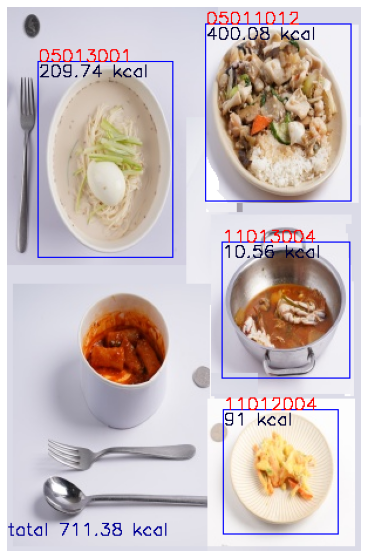

In [18]:

img_path = 'test.png'
cropped_imgs = []
titles = []
kcals = []

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

img = cv2.imread(img_path)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for img_info in img_infos:
    cls, xmin, ymin, xmax, ymax = map(int, img_info)

    cropped_img = transform(img[ymin:ymax, xmin:xmax, :])
    model = ClsModel(num_classes=len(model_info['cls'][cls]))
    model.load_state_dict(torch.load(model_info['path'][cls], map_location=device))  #모델 불러오기

    model = model.to(device)
    model.eval()
    with torch.no_grad():
        cropped_img = cropped_img.to(device)

        out = model(cropped_img.unsqueeze(0))      #기존 3차원에서 배치까지 포함된 4차원에 맞추기 위해 unsqueeze

        preds = torch.argmax(out, dim=-1)
        pred = model_info['cls'][cls][preds.item()]

        row = datasheet.loc[datasheet.folder_name == int(pred)]
        kcal = row['칼로리(kcal)'].item()
        kcals.append(float(kcal))

    text = ' '.join([pred, kcal])
    img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,0,255), 1)
    img = cv2.putText(img, pred, (xmin, ymin), 0, 0.5, (255,0,0), 1, cv2.LINE_4)
    img = cv2.putText(img, kcal+' kcal', (xmin, ymin+13), 0, 0.5, (0,0,50), 1, cv2.LINE_4)

img = cv2.putText(img, f'total {round(sum(kcals),2)} kcal', (0, 450), 0, 0.5, (0,0,150), 1, cv2.LINE_4)
plt.figure(figsize=(10,10))

plt.axis('off')
plt.imshow(img)

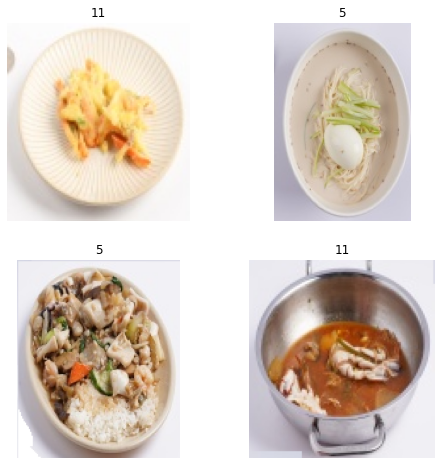

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))
ax = ax.flatten()

for i, cropped_img in enumerate(cropped_imgs):
    ax[i].imshow(cropped_img)
    ax[i].set_title(titles[i])
    ax[i].axis('off')

plt.show()


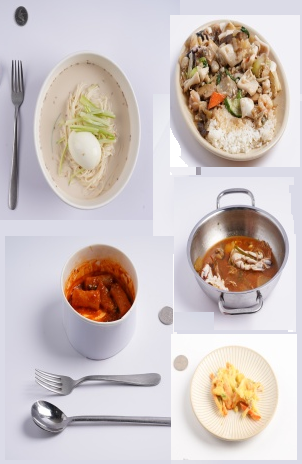

In [2]:
from PIL import Image

im = Image.open('test.png')

im.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

img_path = 'test.png'
cropped_imgs = []
titles = []

img = cv2.imread(img_path)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for img_info in img_infos:
    cls, xmin, ymin, xmax, ymax = map(int, img_info)
    cls = str(cls)

    titles.append(cls)
    cropped_imgs.append(img[ymin:ymax, xmin:xmax, :])
    img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,0,255), 1)
    img = cv2.putText(img, cls, (xmin, ymin), 0, 0.6, (255,0,0), 2, cv2.LINE_4)

plt.figure(figsize=(10,10))

plt.imshow(img)

In [1]:
import pandas as pd

datasheet = pd.read_csv('datasheet.csv')
datasheet.drop(['Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', ], axis=1, inplace=True)

In [8]:
datasheet.head()

,대분류,중분류,소분류,1회제공량(g),칼로리(kcal),kcal per g,folder_name,class,탄수화물,단백질,지방,당 (총당류)
0,밥류,쌀밥류,쌀밥,210,313,1.49,1011001,1,70,5.00,1.60,0.00
1,밥류,잡곡밥류,기타잡곡밥,210,300,1.43,1012001,1,58.65,10.59,1.74,0.64
2,밥류,잡곡밥류,콩밥,210,316,1.50,1012001,1,68.59,9.06,2.23,0.00
3,밥류,잡곡밥류,보리밥,210,312,1.49,1012003,1,77.22,6.09,0.50,5.40
4,밥류,잡곡밥류,돌솥밥,210,380,1.81,1012004,1,75.73,7.21,6.02,1.33


In [29]:
fn = datasheet.folder_name == 1012003

df = datasheet.loc[fn]

kcal = df['칼로리(kcal)'].item()


In [31]:
int('01012003')

1012003